In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
from astropy.time import Time
import sunpy.map

from pathlib import Path
import os, sys
import numpy as np
import datetime

import pdb
import importlib
import pickle, json
import locale
from sunpy.map import all_coordinates_from_map

nlfff_libpath = (Path('./nlfff/binaries/WWNLFFFReconstruction.so').resolve())
radio_libpath = "./rendergrff/binaries/RenderGRFF.so"

from contrib.lff import mf_lfff
from contrib.MagFieldWrapper import MagFieldWrapper
from contrib.radio import GXRadioImageComputing

os.environ['OMP_NUM_THREADS']='16' # number of parallel threads
locale.setlocale(locale.LC_ALL, "C");

In [2]:
import query_sunpy
importlib.reload(query_sunpy);

In [3]:
conf_path = Path("./test_files.json").resolve()
if not conf_path.exists():
    print("does not exist, using default parameters")
    data_path = (Path("./data")).resolve()
    ebtel_file = "/path/to/your/gx_simulator/userslib/aia/ebtel/ebtel.sav"
    jsoc_email = "test@example.com"
else:
    config = json.load(open(str(conf_path), "rb"))
    ebtel_file = config["ebtel_file"]
    jsoc_email = config["jsoc_email"]

In [4]:
def cutout2box (_map, center_x, center_y , dx_km, shape):
    hmi_wcs = _map.wcs

    center_crd = crd = SkyCoord(center_x,center_y, unit=u.arcsec, frame=_map.coordinate_frame)\
                        .transform_to("heliographic_carrington")
    lon = center_crd.lon
    lat = center_crd.lat
    rad = center_crd.radius
    origin = SkyCoord(lon, lat, rad,
                      frame="heliographic_carrington",
                      observer="self",
                      obstime=_map.date)

    scale = np.arcsin(dx_km/origin.radius).to(u.deg)/u.pix
    scale = u.Quantity((scale, scale))
    box_header = sunpy.map.make_fitswcs_header(shape, origin,
                                               projection_code='CEA', scale=scale)

    outmap = _map.reproject_to(box_header, algorithm="adaptive", roundtrip_coords=False)

    return outmap

In [5]:
def hmi_b2ptr(map_field, map_inclination, map_azimuth):
    sz = map_field.data.shape
    ny, nx = sz

    field = map_field.data
    gamma = np.deg2rad(map_inclination.data)
    psi   = np.deg2rad(map_azimuth.data)
    
    b_xi  = -field * np.sin(gamma) * np.sin(psi)
    b_eta  = field * np.sin(gamma) * np.cos(psi)
    b_zeta = field * np.cos(gamma)

    foo = all_coordinates_from_map(map_field).transform_to("heliographic_stonyhurst")
    phi = foo.lon
    lambda_  = foo.lat

    b = np.deg2rad(map_field.fits_header["crlt_obs"])
    p = np.deg2rad(-map_field.fits_header["crota2"])
    
    phi, lambda_ = np.deg2rad(phi), np.deg2rad(lambda_)

    sinb, cosb = np.sin(b), np.cos(b)
    sinp, cosp = np.sin(p), np.cos(p)
    sinphi, cosphi = np.sin(phi), np.cos(phi)          # nx*ny
    sinlam, coslam = np.sin(lambda_), np.cos(lambda_)  # nx*ny

    k11 = coslam * (sinb * sinp * cosphi + cosp * sinphi) - sinlam * cosb * sinp
    k12 = - coslam * (sinb * cosp * cosphi - sinp * sinphi) + sinlam * cosb * cosp
    k13 = coslam * cosb * cosphi + sinlam * sinb
    k21 = sinlam * (sinb * sinp * cosphi + cosp * sinphi) + coslam * cosb * sinp
    k22 = - sinlam * (sinb * cosp * cosphi - sinp * sinphi) - coslam * cosb * cosp
    k23 = sinlam * cosb * cosphi - coslam * sinb
    k31 = - sinb * sinp * sinphi + cosp * cosphi
    k32 = sinb * cosp * sinphi + sinp * cosphi
    k33 = - cosb * sinphi

    bptr = np.zeros((3,nx, ny))

    bptr[0,:,:] = k31 * b_xi + k32 * b_eta + k33 * b_zeta
    bptr[1,:,:] = k21 * b_xi + k22 * b_eta + k23 * b_zeta
    bptr[2,:,:] = k11 * b_xi + k12 * b_eta + k13 * b_zeta

    header = map_field.fits_header
    map_bp = sunpy.map.Map(bptr[0,:,:], header)
    map_bt = sunpy.map.Map(bptr[1,:,:], header)
    map_br = sunpy.map.Map(bptr[2,:,:], header)
    
    
    return map_bp, map_bt, map_br

In [6]:
dl_path = "input_data/"

In [7]:
start_date = datetime.datetime.fromisoformat("2014-02-02T02:22:00.0")
end_date   = datetime.datetime.fromisoformat("2014-02-02T02:22:15.0")

In [8]:
#query_sunpy.download_magnetograms(start_date, end_date, dl_path, jsoc_email, print_only=True)

In [9]:
#query_sunpy.download_magnetograms(start_date, end_date, dl_path, jsoc_email, print_only=False)

In [10]:
#def gx_box_from_dir(cache_dir, model_dir, x, y, dx, dy, dz, res_km, top=0, cea=1, sfq=1, carrington=0):

x=-230
y=-110
dx=512
dy=256
dz=256

res_km=360.49

input_path = Path(os.path.expanduser(dl_path)).resolve()

if not input_path.exists():
    print("no input data")

field_path = list(input_path.glob("*.field.fits"))[0]
incli_path = list(input_path.glob("*.inclination.fits"))[0]
azimu_path = list(input_path.glob("*.azimuth.fits"))[0]
disam_path = list(input_path.glob("*.disambig.fits"))[0]
conti_path = list(input_path.glob("*.continuum.fits"))[0]
losma_path = list(input_path.glob("*.magnetogram.fits"))[0]
size_pix = f"[{dx}, {dy}, {dz}]"
centre = f"[{x}, {y}]"
wcs_rsun=6.96e8

In [11]:
#reading data from fits
map_field       = sunpy.map.Map(field_path)
map_inclination = sunpy.map.Map(incli_path)
map_azimuth     = sunpy.map.Map(azimu_path)
map_disambig    = sunpy.map.Map(disam_path)

See https://docs.sunpy.org/en/stable/how_to/fix_map_metadata.html for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/how_to/fix_map_metadata.html for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


In [12]:
map_conti = sunpy.map.Map(conti_path)
map_losma = sunpy.map.Map(losma_path)

In [13]:
#disambiguation
dis = map_disambig.data
map_azimuth.data[:,:] = map_azimuth.data + dis*180.

map_bp, map_bt, map_br = hmi_b2ptr(map_field, map_inclination, map_azimuth)
box_bx = cutout2box(map_bp, x, y, res_km * u.km, [dy, dx])
box_by = cutout2box(map_bt, x, y, res_km * u.km, [dy, dx])
box_bz = cutout2box(map_br, x, y, res_km * u.km, [dy, dx])
box_by.data[:,:] *= -1

See https://docs.sunpy.org/en/stable/how_to/fix_map_metadata.html for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


In [14]:
earth_observer = SkyCoord(0*u.deg, 0*u.deg, 0*u.km, frame=frames.GeocentricEarthEquatorial, observer="earth", obstime=box_bx.date)

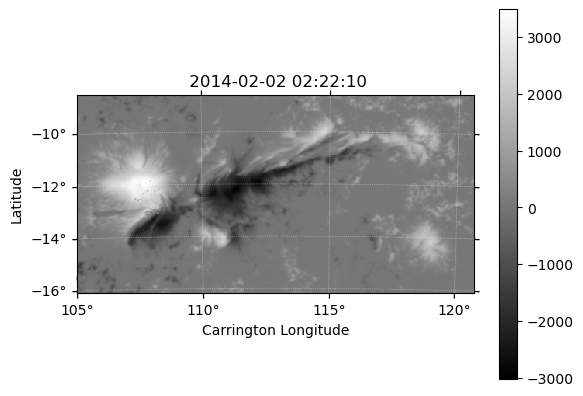

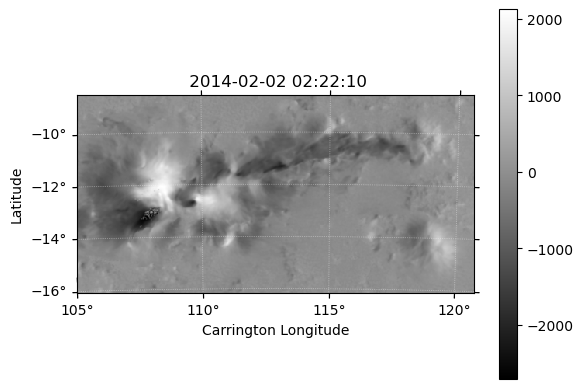

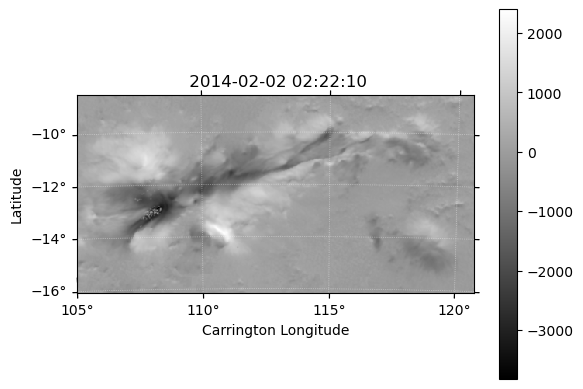

In [15]:
box_bz.peek()
box_bx.peek()
box_by.peek()

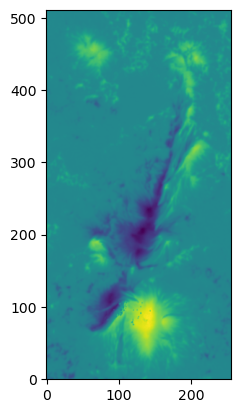

In [16]:
plt.imshow(box_bz.data.T, origin="lower")

In [17]:
maglib_lff = mf_lfff()
maglib_lff.set_field(box_bz.data.T)

In [18]:
res1 = maglib_lff.lfff_cube(dz)

In [19]:
bx_lff, by_lff, bz_lff = [res1[k].transpose((2, 1, 0)) for k in ("bx", "by", "bz")]

In [20]:
bx_lff.shape

(256, 256, 512)

In [21]:
maglib = MagFieldWrapper(nlfff_libpath)

dr = (map_field.rsun_obs / map_field.rsun_meters * res_km).value
maglib.load_cube_vars(bx_lff, by_lff, bz_lff, dr)

box = maglib.NLFFF()
energy_new = maglib.energy
print('NLFFF energy:     ' + str(energy_new) + ' erg')

print("Calculating field lines")
lines = maglib.lines(seeds = None)

NLFFF energy:     1.5011120715875637 erg
Calculating field lines


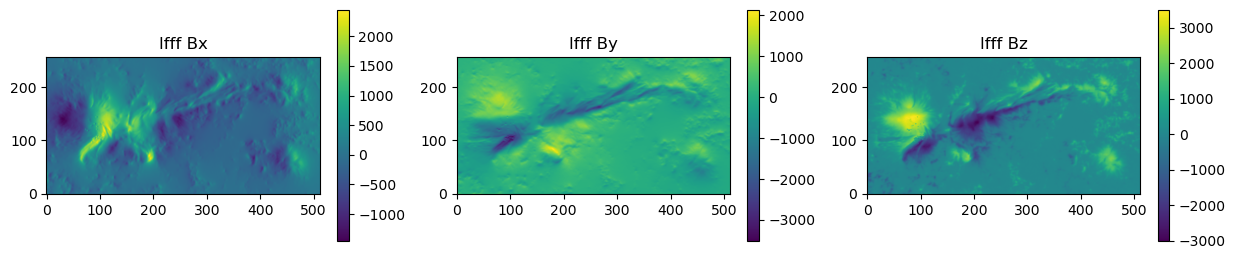

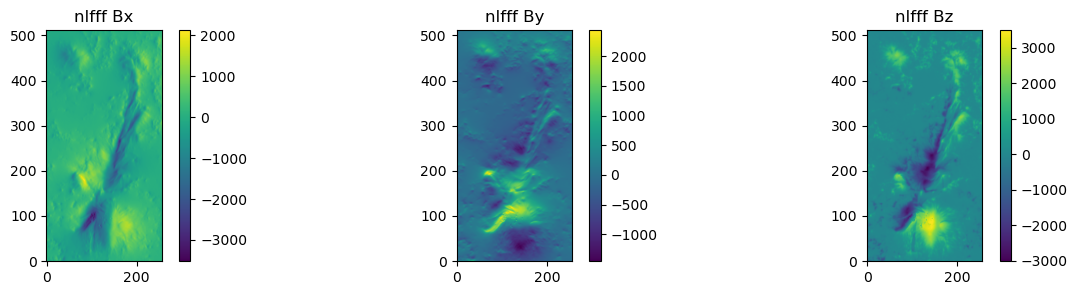

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
axes = (ax1, ax2, ax3)

for a, arr, ttl in zip(axes, (bx_lff, by_lff, bz_lff), ("Bx", "By", "Bz")):
    im = a.imshow(arr[0, :, :], origin="lower")
    plt.colorbar(im, ax=a)
    a.set_title("lfff " + ttl)
fig.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
axes = (ax1, ax2, ax3)

for a, arr, ttl in zip(axes, (box["bx"], box["by"], box["bz"]), ("Bx", "By", "Bz")):
    im = a.imshow(arr[0, :, :], origin="lower")
    plt.colorbar(im, ax=a)
    a.set_title("nlfff " + ttl)
fig.show()

In [23]:
base_bz = cutout2box(map_losma, x, y, res_km * u.km, [dy, dx])
base_ic = cutout2box(map_conti, x, y, res_km * u.km, [dy, dx])

In [24]:
dr3 = [dr, dr, dr]
dr3

[0.000504333497436348, 0.000504333497436348, 0.000504333497436348]

In [25]:
import gx_chromo.combo_model

In [26]:
importlib.reload(gx_chromo.combo_model)

<module 'gx_chromo.combo_model' from '/home/fedenyov/pyAMPP/gx_chromo/combo_model.py'>

In [27]:
#box["bx"].T.shape

In [28]:
chromo_box=gx_chromo.combo_model.combo_model(box, dr3, base_bz.data.T, base_ic.data.T)

cutoff_qs:  0.9895731527762722 19365
cutoff_b:  1.0063878506109603
cutoff_f:  1.0315768916245416
umbra: nelem=  15797  abs(B) range:  0.9108180790868368 3765.7703869109896
penumbra: nelem=  28169  abs(B) range:  0.03361621560850276 1398.9023916154888
eNW: nelem=  2614  abs(B) range:  0.0012175173683434065 306.58630668578246
NW: nelem=  19163  abs(B) range:  0.0009513811560782625 425.10619021914897
IN: nelem=  65329  abs(B) range:  0.0004509763385351691 928.2673949527475
plage: nelem=  46385  abs(B) range:  30.00010601645996 725.6833268946167
facula: nelem=  17423  abs(B) range:  30.000493974860422 496.95731749350324
Total elements:  194880
Number of elements in cont:  131072


In [29]:
chromo_box["avfield"] = lines["av_field"].transpose((1, 2, 0))
chromo_box["physlength"] = lines["phys_length"].transpose((1, 2, 0)) * dr3[0]
chromo_box["status"] = lines["voxel_status"].transpose((1, 2, 0))

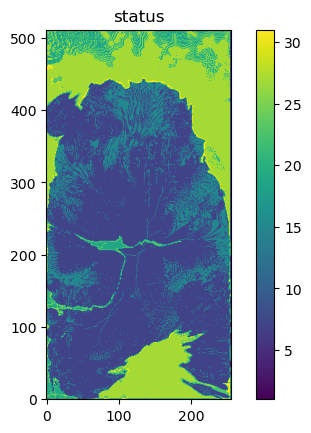

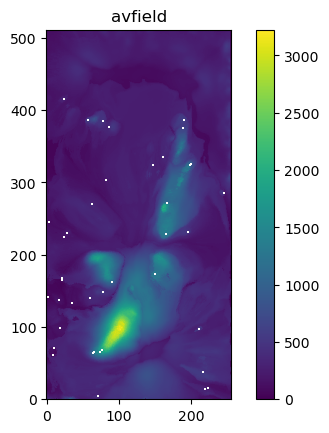

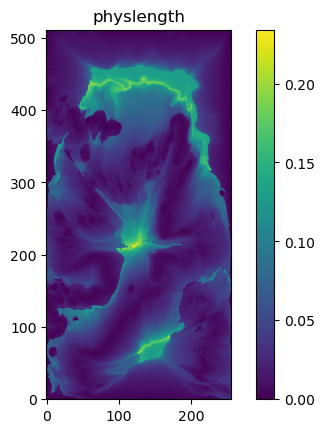

In [30]:
for k in ("status", "avfield", "physlength"):
    plt.figure()
    plt.title(k)
    plt.imshow(chromo_box[k][:, :, 1], origin="lower", interpolation=None)
    plt.colorbar()
    plt.show()

In [31]:
header_field = map_field.wcs.to_header()
field_frame  = box_bx.center.heliographic_carrington.frame
lon, lat = field_frame.lon.value, field_frame.lat.value

obs_time = Time(map_field.date)
dsun_obs = header_field["DSUN_OBS"]

header = {"lon":lon, "lat":lat, "dsun_obs": dsun_obs, "obs_time": obs_time}

In [32]:
header

{'lon': 112.87672285154,
 'lat': -12.382895696595995,
 'dsun_obs': 147435526900.74,
 'obs_time': <Time object: scale='utc' format='isot' value=2014-02-02T02:22:10.300>}

In [33]:
gxi = GXRadioImageComputing(radio_libpath)

In [34]:
ebtel, ebtel_dt = gxi.load_ebtel(ebtel_file)
model, model_dt = gxi.load_model_dict(chromo_box, header)

In [35]:
box_Nx=150
box_Ny=150
box_xc=-230
box_yc=-110
box_dx=2.0
box_dy=2.0

freqlist=[17.0, 34.0]

Tbase=1e6
nbase=1e8
Q0=4.5e-3
a=1.5
b=2.5

results = gxi.synth_model(model, model_dt,
                          ebtel, ebtel_dt, freqlist,
                          box_Nx, box_Ny, box_xc, box_yc, box_dx, box_dy, Tbase, nbase, Q0, a, b, force_isothermal=1)

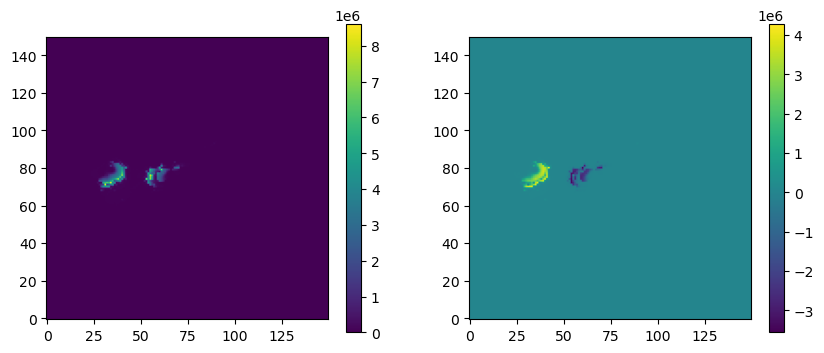

In [36]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
i1 = ax1.imshow(np.transpose(results["TI"][:, :, 0]), origin='lower')
i2 = ax2.imshow(np.transpose(results["TV"][:, :, 0]), origin='lower')

plt.colorbar(i1, ax=ax1)
plt.colorbar(i2, ax=ax2)

plt.show()

In [37]:
results["TI"][20:80, 60:100, 0]

array([[17612.85490787, 17350.07142247, 17297.68258211, ...,
        17738.452214  , 17316.43317679, 17045.83475392],
       [14034.18438799, 13875.39236793, 14416.19732275, ...,
        15505.40952668, 15085.87141074, 17085.78873241],
       [14737.22874439, 14553.42509281, 14359.24934672, ...,
        17307.02236459, 17054.56976256, 17010.85783737],
       ...,
       [17780.61406897, 17490.57512761, 17343.98189789, ...,
        19045.51997108, 18540.22473257, 18142.61642251],
       [17547.5747511 , 17392.8781749 , 17326.70229889, ...,
        15646.28546444, 15666.1820917 , 14973.47589629],
       [17502.90216565,  9410.77992983, 17227.05542523, ...,
        18647.60014872, 18292.88434108, 17936.76448733]])